source: https://www.kaggle.com/code/enesztrk/facial-emotion-recognition-vgg19-fer2013

In [25]:
import math
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
%cd /content/drive/MyDrive/Humber AI ML/AIGC 5505 - FER

/content/drive/MyDrive/Humber AI ML/AIGC 5505 - FER


# Reading the Data

In [28]:
df = pd.read_csv("train.csv")

In [29]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [30]:
df.shape

(28709, 2)

In [31]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

Note: 28,709 images in the training set

In [32]:
def positive_negative(x):
    if x in [0,1,2,4]:
        return 0 #negative
    elif x in [3,5]:
        return 2 #positive
    else:
        return 1 #neutral

In [33]:
df['labels'] = df.apply(lambda x: positive_negative(x['emotion']), axis=1)

In [34]:
# Get the labels
labels = np.array(df['labels'])

In [35]:
df['labels'].value_counts()

0    13358
2    10386
1     4965
Name: labels, dtype: int64

In [37]:
# Change labels to one hot
labels = np_utils.to_categorical(labels, num_classes=3)

In [38]:
# Extract the pixels and reshape them into a 48x48 image
images = []
for image_pixels in df.iloc[:,1]: # column 2 has the pixels
    image_string = image_pixels.split(' ') # pixels are separated by spaces
    # get the integer value and reshape into 2D
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
    images.append(image_data)

In [39]:
images = np.array(images)

In [40]:
images.shape

(28709, 48, 48)

## Extracting Features to RGB

In [41]:
img_features = []

for i in range(len(images)):
    temp = cv2.cvtColor(images[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(28709, 48, 48, 3)


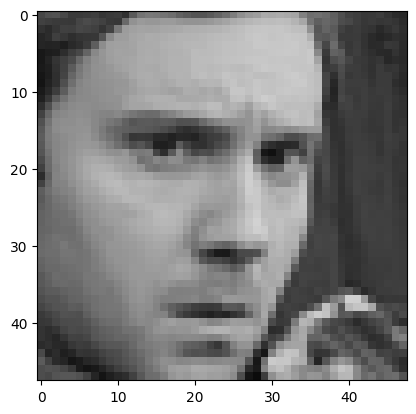

In [42]:
plt.imshow(img_features[0].astype(np.uint8));

# Model Building

In [43]:
# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      labels,
                                                      shuffle = True,
                                                      stratify = labels,
                                                      test_size = 0.1,
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((25838, 48, 48, 3), (2871, 48, 48, 3), (25838, 3), (2871, 3))

In [44]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [45]:
# Standardize dataset.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [46]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [47]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [48]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

In [49]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [50]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [51]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [52]:
batch_size = 32
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [53]:
history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/25
807/807 [==============================] - 71s 64ms/step - loss: 0.8780 - accuracy: 0.5907 - val_loss: 0.6836 - val_accuracy: 0.6914 - lr: 1.0000e-04
Epoch 2/25
807/807 [==============================] - 52s 64ms/step - loss: 0.7066 - accuracy: 0.6892 - val_loss: 0.6447 - val_accuracy: 0.7259 - lr: 1.0000e-04
Epoch 3/25
807/807 [==============================] - 47s 58ms/step - loss: 0.6455 - accuracy: 0.7257 - val_loss: 0.6045 - val_accuracy: 0.7447 - lr: 1.0000e-04
Epoch 4/25
807/807 [==============================] - 49s 61ms/step - loss: 0.6059 - accuracy: 0.7455 - val_loss: 0.5504 - val_accuracy: 0.7684 - lr: 1.0000e-04
Epoch 5/25
807/807 [==============================] - 49s 61ms/step - loss: 0.5807 - accuracy: 0.7575 - val_loss: 0.5250 - val_accuracy: 0.7851 - lr: 1.0000e-04
Epoch 6/25
807/807 [==============================] - 46s 57ms/step - loss: 0.5567 - accuracy: 0.7688 - val_loss: 0.6054 - val_accuracy: 0.7524 - lr: 1.0000e-04
Epoch 7/25
807/807 [==============

In [55]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model.h5")

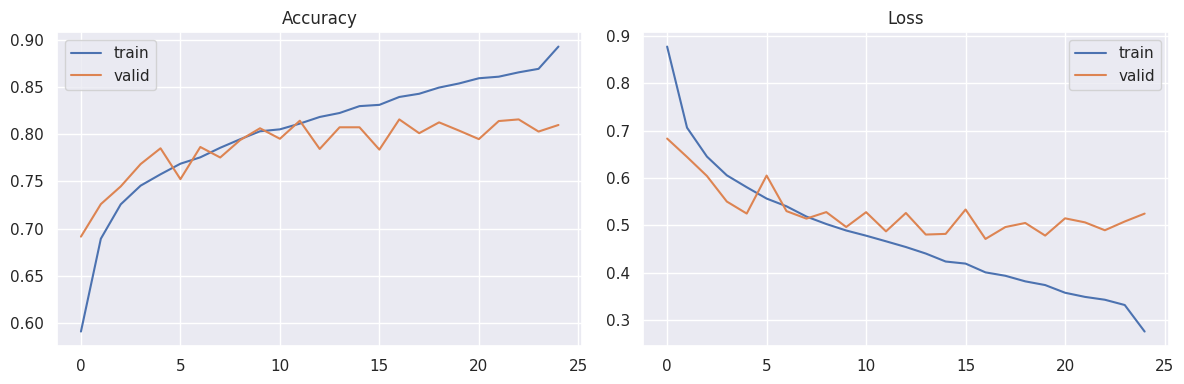

In [54]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()